[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/broadinstitute/protSCP/blob/main/find_clusters.ipynb)
# Stability Clustering Pipeline

## Setup: Install the Library

In [7]:
! git clone https://github.com/broadinstitute/protSCP.git
%cd protSCP
! pip install -r requirements.txt

Cloning into 'protSCP'...
remote: Enumerating objects: 10257, done.
remote: Counting objects: 100% (10257/10257), done.
remote: Compressing objects: 100% (7672/7672), done.
remote: Total 10257 (delta 2590), reused 10241 (delta 2579), pack-reused 0 (from 0)
Receiving objects: 100% (10257/10257), 27.71 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (2590/2590), done.
Updating files: 100% (10211/10211), done.
/content/protSCP/protSCP/protSCP


## Stage 1: <i>In Silico</i> Saturation Mutagenesis
### Stage 1.1: Getting FoldX data using MutateX
1. Install the [FoldX](https://foldxsuite.crg.eu/) binary (currently for FoldX5) and the PDB or PDBs.
2. Install [MutateX](https://www.github.com/elelab/mutatex)
3. Use MutateX with FoldX's BuildModel command (Repair step recommended) to compute FoldX values.
See the recommended configuration used in the study, [attached](foldx_cfg/).

### Stage 1.2: Parsing raw FoldX data and Protein Structure data

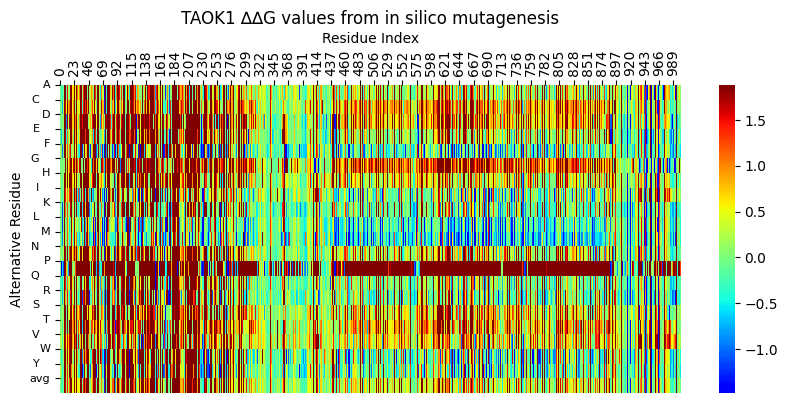

In [3]:
"""
Function: prepare_protein_dataset
Description: Preprocess raw mutatex results and Protein Structure data.
Args:
    [required] raw_mutatex_filename: path to raw mutatex results
    [required for AlphaFoldDB Structure] uniprot_id: UniProt ID of the protein
    [required for mmCIF Structure] cif_path: path to mmCIF file
Returns:
    cluster_df: pandas dataframe with mutatex and structure data for clustering
"""
from ddg_clustering.prepare_data import prepare_protein_dataset

datapath = "sample_data/TAOK1_Q7L7X3_mutatex_af2_results/"
uniprot_id = "Q7L7X3"
gene = "TAOK1"
clust_df = prepare_protein_dataset(datapath, uniprot_id)

"""
Function: ddg_heatmap
Description: Visualize ∆∆G values on a heatmap of mutational landscape.
Args:
    [required] gene: gene name
    [required] cluster_df: dataframe with ∆∆G values for all residues
    [optional] chain: chain to visualize, default is A
    [optional] start: start residue to visualize, default is 1
    [optional] end: end residue to visualize, default is last residue
Returns:
    None
"""
from ddg_clustering.visualize import ddg_heatmap
ddg_heatmap(gene, clust_df)

## Stage 2: Hit and Site Prioritization

95% quantile: 6.998879585491188


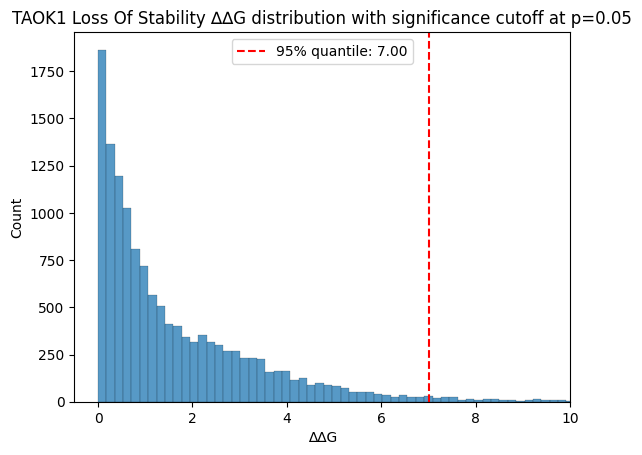

95% quantile: 1.5414825168048232


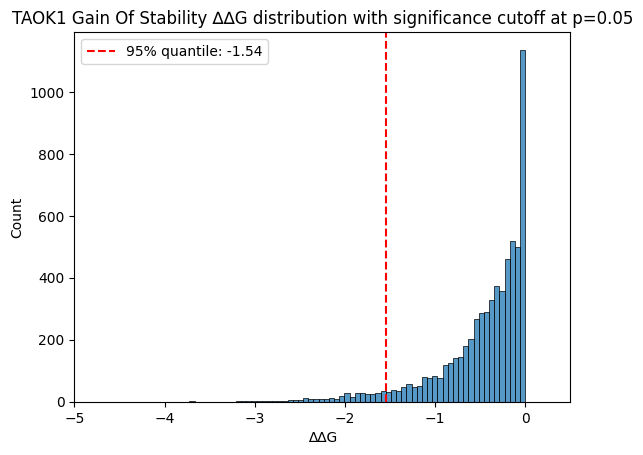

In [4]:
"""
Function: prioritize_sites
Description: Prioritize sites for clustering.
Args:
    [required] cluster_df: dataframe with ∆∆G values for all residues
    [optional] type: ClusterType.LOSS_OF_STABILITY or ClusterType.GAIN_OF_STABILITY
                    default is ClusterType.LOSS_OF_STABILITY
    [optional] metric: Metric.SIGNIFICANCE or Metric.THRESHOLD
                    default is Metric.SIGNIFICANCE
    [optional, used for SIGNIFICANCE] pvalue: p-value cutoff, default is 0.05
    [optional, used for SIGNIFICANCE] distribution: distribution to fit, default is stats.gengamma
    [optional, used for THRESHOLD] cutoff: number of mutations above cutoff for a
                    residue to be prioritized, default is 15. Select 1-19.
                    For example, if cutoff=15, then a residue is prioritized if
                    there are 15 or more mutations at a residue index that have a
                    ∆∆G value above the cutoff (L123P, L123Q, L123C, L123F, etc.)
Returns:
    prioritized_sites: dataframe with prioritized sites
"""
from ddg_clustering.clustering import prioritize_sites, ClusterType, Metric
from scipy import stats

los_cluster_type = ClusterType.LOSS_OF_STABILITY
gos_cluster_type = ClusterType.GAIN_OF_STABILITY
metric = Metric.SIGNIFICANCE # Cutoff using p-value. Alternative is THRESHOLD, which uses a fixed cutoff
pvalue = 0.05 # default p-value
distribution = stats.gengamma # default distribution due to best fit

los_prioritized_sites = prioritize_sites(clust_df, type=los_cluster_type, metric=metric,
                                     pvalue=pvalue, distribution=distribution)
gos_prioritized_sites = prioritize_sites(clust_df, type=gos_cluster_type, metric=metric,
                                     pvalue=pvalue, distribution=distribution)

"""
Function: visualize_threshold_hits
Description: Distribution of ∆∆G values with threshold shown.
Args:
    [required] gene: gene name
    [required] cluster_df: dataframe with ∆∆G values for all residues
    [optional] cluster_type: ClusterType.LOSS_OF_STABILITY or ClusterType.GAIN_OF_STABILITY
    [optional] metric: Metric.SIGNIFICANCE or Metric.THRESHOLD
    [optional, used for SIGNIFICANCE] pvalue: p-value cutoff, default is 0.05
    [optional, used for SIGNIFICANCE] distribution: distribution to fit, default is stats.gengamma
Returns:
    None
"""
from ddg_clustering.visualize import visualize_threshold_hits
visualize_threshold_hits(gene, clust_df, cluster_type=los_cluster_type, metric=metric,
                         pvalue=pvalue, distribution=distribution)
visualize_threshold_hits(gene, clust_df, cluster_type=gos_cluster_type, metric=metric,
                         pvalue=pvalue, distribution=distribution)


## Stage 3: 3-Dimensional Clustering

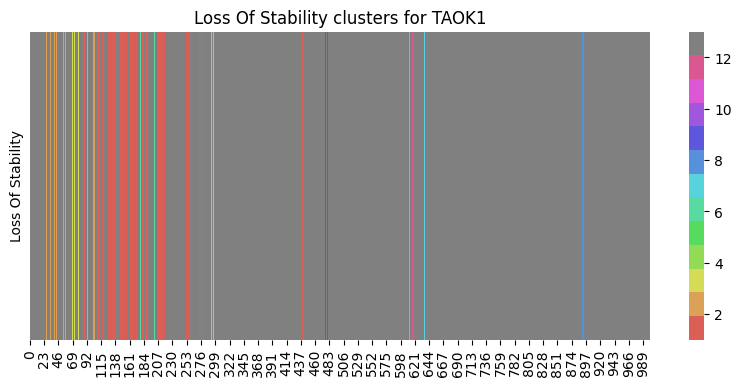

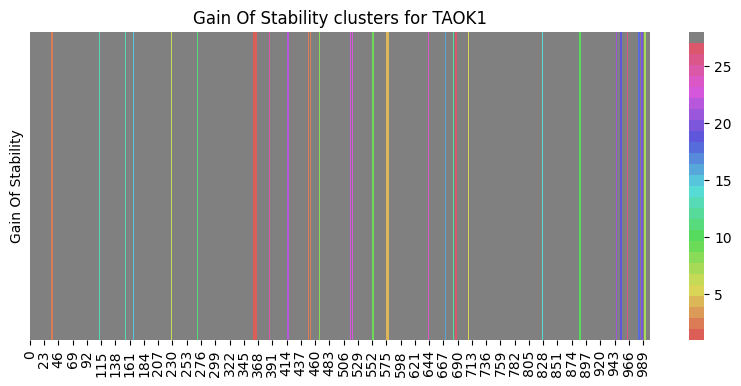

In [5]:

"""
Function: cluster_prioritized_sites
Description: Cluster prioritized sites.
Args:
    [required] prioritized_sites: dataframe with prioritized sites to cluster
    [required] cluster_df: dataframe with ∆∆G values for all residues and x,y,z coordinates
                (from Protein Structure data) for 3D clustering
    [optional] min_cluster_size: minimum cluster size, default is 5
    [optional] distance_threshold: distance threshold for clustering, default is 6 (Angstroms)
Returns:
    clusters: list of clusters
"""
from ddg_clustering.clustering import cluster_prioritized_sites

los_clusters = cluster_prioritized_sites(los_prioritized_sites, clust_df, min_cluster_size=2, distance_threshold=6)
gos_clusters = cluster_prioritized_sites(gos_prioritized_sites, clust_df, min_cluster_size=2, distance_threshold=6)

"""
Function: visualize_clusters_on_sequence
Description: Categorically color clusters on sequence.
Args:
    [required] gene: gene name
    [required] cluster_results_df: final dataframe with cluster column and cluster index for each residue
    [optional] cluster_type: ClusterType.LOSS_OF_STABILITY or ClusterType.GAIN_OF_STABILITY
                    default is ClusterType.LOSS_OF_STABILITY
Returns:
    None
"""
from ddg_clustering.visualize import visualize_clusters_on_sequence
visualize_clusters_on_sequence(gene, los_clusters[0], cluster_type=los_cluster_type)
visualize_clusters_on_sequence(gene, gos_clusters[0], cluster_type=gos_cluster_type)


"""
Function: save_clusters
Description: Save clusters to a CSV file.
Args:
    [required] filename: filename to save clusters
    [required] clusters: list of clusters
Returns:
    None
"""
from ddg_clustering.clustering import save_clusters

save_clusters("TAOK1_loss_of_stability_clusters.csv", los_clusters)
save_clusters("TAOK1_gain_of_stability_clusters.csv", gos_clusters)


## Visualizing Clusters
#### 1. Go to the [G2P portal](g2p.broadinstitute.org)

#### 2. Select "Interactive Mapping"
<img src="https://github.com/broadinstitute/protSCP/blob/main/sample_screenshots/01home.png?raw=1" style="height:330px;width:600px">

#### 3. Select "Start with a gene..." for an existing PDB or AlphaFold structure
<img src="https://github.com/broadinstitute/protSCP/blob/main/sample_screenshots/02mapping_option.png?raw=1" style="height:330px;width:600px">

#### 4. Search and select gene (ie TAOK1)
<img src="https://github.com/broadinstitute/protSCP/blob/main/sample_screenshots/03gene.png?raw=1" style="height:330px;width:600px">

#### 5. Select the AlphaFold structure
<img src="https://github.com/broadinstitute/protSCP/blob/main/sample_screenshots/04structure.png?raw=1" style="height:330px;width:600px">

#### 6. Upload the cluster annotation CSV
<img src="https://github.com/broadinstitute/protSCP/blob/main/sample_screenshots/05upload.png?raw=1" style="height:330px;width:600px">

#### 7. Fix the column types in the validations for aa, chain, and clusters.
Set aa, chain, and clusters columns to all have the "features" type for categorical features.

<img src="https://github.com/broadinstitute/protSCP/blob/main/sample_screenshots/06types.png?raw=1" style="height:300px;width:600px">

<img src="https://github.com/broadinstitute/protSCP/blob/main/sample_screenshots/07types.png?raw=1" style="height:60px;width:600px">

#### 8. Map the results!
Click on the cluster row label to map the cluster data from the protein sequence to the protein structure.

<img src="https://github.com/broadinstitute/protSCP/blob/main/sample_screenshots/08results.png?raw=1" style="height:360px;width:600px">

